In [1]:
import os
import h5py
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import shape, LineString
from scipy.ndimage import measurements

from modis_utils.misc import restore_data, cache_data

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = restore_data('cache/boundary_vectors_ALL.h5')

In [3]:
data_dir = 'data_boundary_matrix'
data_train = restore_data(os.path.join(data_dir, 'train.dat'))
data_val = restore_data(os.path.join(data_dir, 'val.dat'))
data_test = restore_data(os.path.join(data_dir, 'test.dat'))

In [4]:
groundtruth_dir = 'boundaries_matrix'
groundtruth_train = restore_data(os.path.join(groundtruth_dir, 'train.dat'))
groundtruth_val = restore_data(os.path.join(groundtruth_dir, 'val.dat'))
groundtruth_test = restore_data(os.path.join(groundtruth_dir, 'test.dat'))

In [5]:
groundtruth_train = np.expand_dims(groundtruth_train, axis=-1)
groundtruth_val = np.expand_dims(groundtruth_val, axis=-1)
groundtruth_test = np.expand_dims(groundtruth_test, axis=-1)

In [6]:
data_train.shape, data_val.shape, data_test.shape

((438, 513, 513, 1), (138, 513, 513, 1), (138, 513, 513, 1))

In [7]:
groundtruth_train.shape, groundtruth_val.shape, groundtruth_test.shape

((438, 513, 513, 1), (138, 513, 513, 1), (138, 513, 513, 1))

In [8]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Add, PReLU, Conv2DTranspose, Concatenate, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras import backend as K
import tensorflow as tf


class L0Loss:
    def __init__(self):
        self.gamma = K.variable(2.)

    def __call__(self):
        def calc_loss(y_true, y_pred):
            loss = K.pow(K.abs(y_true - y_pred) + 1e-8, self.gamma)
            return loss
        return calc_loss


class UpdateAnnealingParameter(Callback):
    def __init__(self, gamma, nb_epochs, verbose=0):
        super(UpdateAnnealingParameter, self).__init__()
        self.gamma = gamma
        self.nb_epochs = nb_epochs
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        new_gamma = 2.0 * (self.nb_epochs - epoch) / self.nb_epochs
        K.set_value(self.gamma, new_gamma)

        if self.verbose > 0:
            print('\nEpoch %05d: UpdateAnnealingParameter reducing gamma to %s.' % (epoch + 1, new_gamma))


def tf_log10(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def PSNR(y_true, y_pred):
    max_pixel = 255.0
    y_pred = K.clip(y_pred, 0.0, 255.0)
    return 10.0 * tf_log10((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))


def get_model(input_shape, model_name="srresnet"):
    if model_name == "srresnet":
        return get_srresnet_model(input_shape)
    elif model_name == "unet":
        return get_unet_model(input_shape)
    else:
        raise ValueError("model_name should be 'srresnet'or 'unet'")


# SRResNet
def get_srresnet_model(input_shape, input_channel_num=1, feature_dim=64, resunit_num=16):
    def _residual_block(inputs):
        x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
        x = BatchNormalization()(x)
        x = PReLU(shared_axes=[1, 2])(x)
        x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        x = BatchNormalization()(x)
        m = Add()([x, inputs])

        return m

    inputs = Input(shape=(input_shape[0], input_shape[1], input_channel_num))
    x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
    x = PReLU(shared_axes=[1, 2])(x)
    x0 = x

    for i in range(resunit_num):
        x = _residual_block(x)

    x = Conv2D(feature_dim, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Add()([x, x0])
    x = Conv2D(input_channel_num, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    model = Model(inputs=inputs, outputs=x)

    return model


# UNet: code from https://github.com/pietz/unet-keras
def get_unet_model(input_shape, input_channel_num=1, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    def _conv_block(m, dim, acti, bn, res, do=0):
        n = Conv2D(dim, 3, activation=acti, padding='same')(m)
        n = BatchNormalization()(n) if bn else n
        n = Dropout(do)(n) if do else n
        n = Conv2D(dim, 3, activation=acti, padding='same')(n)
        n = BatchNormalization()(n) if bn else n

        return Concatenate()([m, n]) if res else n

    def _level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
        if depth > 0:
            n = _conv_block(m, dim, acti, bn, res)
            m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
            m = _level_block(m, int(inc * dim), depth - 1, inc, acti, do, bn, mp, up, res)
            if up:
                m = UpSampling2D()(m)
                m = Conv2D(dim, 2, activation=acti, padding='same')(m)
            else:
                m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
            n = Concatenate()([n, m])
            m = _conv_block(n, dim, acti, bn, res)
        else:
            m = _conv_block(m, dim, acti, bn, res, do)

        return m

    i = Input(shape=(input_shape[0], input_shape[1], input_channel_num))
    o = _level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1)(o)
    model = Model(inputs=i, outputs=o)

    return model

In [9]:
def boundary_loss(groundtruth, predict):
    square_error = (groundtruth - predict)**2
    square_error = tf.reduce_sum(square_error, axis=[1,2,3])
    s = tf.reduce_sum(groundtruth, axis=[1,2,3])
    return tf.divide(square_error, s)

In [10]:
K.clear_session()
model = get_model(input_shape=(513, 513))
model.compile(loss=boundary_loss, optimizer='adam')

In [11]:
#model.fit(data_train, groundtruth_train, batch_size=1, epochs=2, verbose=1,
#          validation_data=(data_val, groundtruth_val))

In [12]:
model.load_weights('boundary_sample_to_image.h5')

In [13]:
#for i in range(data_test.shape[0]):
#    model.evaluate(x=data_test[i:i+1], y=groundtruth_test[i:i+1])

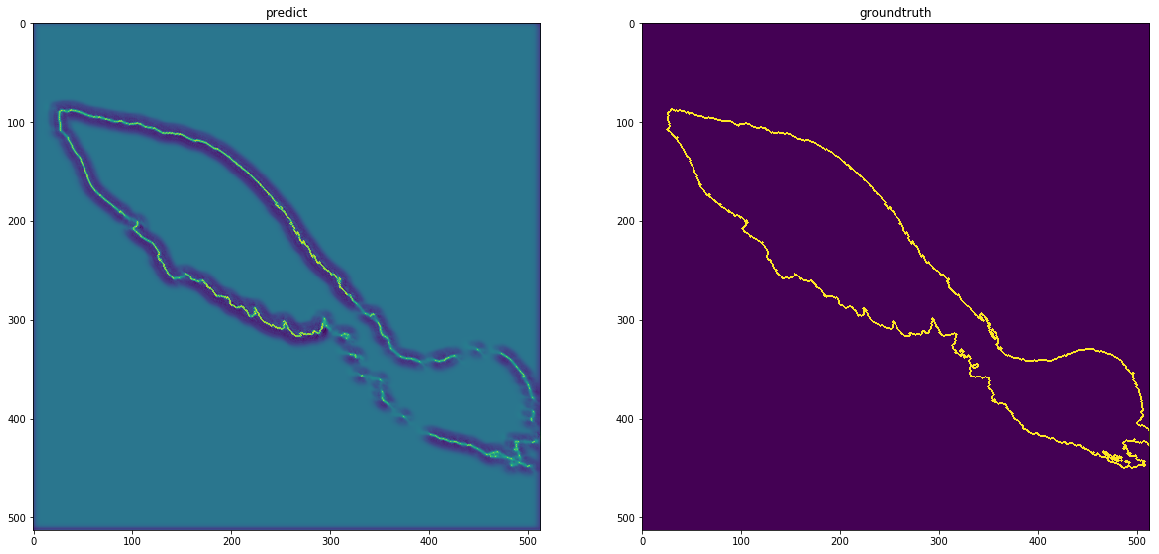

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
predict = x.squeeze(axis=0).squeeze(axis=-1)
ax[0].imshow(predict)
ax[0].set_title('predict')

groundtruth = groundtruth_test[idx:idx+1].squeeze(axis=0).squeeze(axis=-1)
ax[1].imshow(groundtruth)
ax[1].set_title('groundtruth')
plt.savefig('result/boundary_vectors_2_image_{}.png'.format(idx))

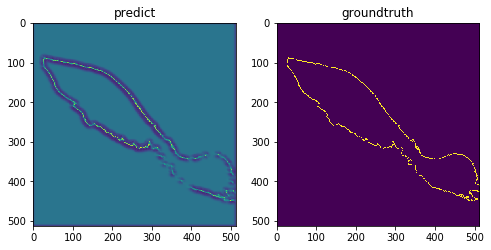

In [15]:
idx = 0
x = model.predict(data_test[idx:idx+1])
fig, ax = plt.subplots(1,2, figsize=(8,20))
predict = x.squeeze(axis=0).squeeze(axis=-1)
ax[0].imshow(predict)
ax[0].set_title('predict')

groundtruth = groundtruth_test[idx:idx+1].squeeze(axis=0).squeeze(axis=-1)
ax[1].imshow(groundtruth)
ax[1].set_title('groundtruth')
plt.savefig('result/boundary_vectors_2_image_{}.png'.format(idx))

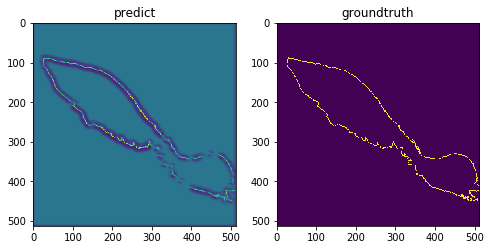

In [16]:
idx = 1
x = model.predict(data_test[idx:idx+1])
fig, ax = plt.subplots(1,2, figsize=(8,20))
predict = x.squeeze(axis=0).squeeze(axis=-1)
ax[0].imshow(predict)
ax[0].set_title('predict')

groundtruth = groundtruth_test[idx:idx+1].squeeze(axis=0).squeeze(axis=-1)
ax[1].imshow(groundtruth)
ax[1].set_title('groundtruth')
plt.savefig('result/boundary_vectors_2_image_{}.png'.format(idx))

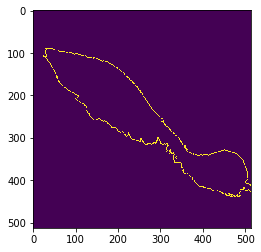

In [30]:
idx = 5
groundtruth = groundtruth_test[idx:idx+1].squeeze(axis=0).squeeze(axis=-1)
plt.imshow(groundtruth)

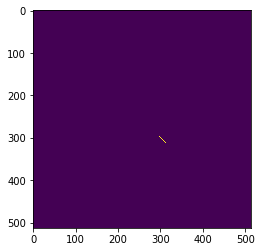

In [32]:
idx = 5
x = data_train[idx:idx+1].squeeze(axis=0).squeeze(axis=-1)

plt.imshow(x)